In [1]:
# Using matplotlib on a notebook
%matplotlib notebook

In [2]:
# Libraries
import math
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from datetime import datetime, timedelta
from matplotlib.patches import Polygon
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PatchCollection
from scipy.spatial import KDTree
# Note: whether the PC is a Windows PC, the user must tell where the ffmpeg application is installed:
# mpl.rcParams['animation.ffmpeg_path'] = r'C:\\Users\\xx\\Desktop\\ffmpeg\\bin\\ffmpeg.exe'

In [3]:
# Load the datafile
fn = '../dataedge/Washington-1m-2008-09_UGRID.nc'
ds = nc.Dataset(fn)

In [4]:
# Load the data into variables
zonal_lon      = ds.variables["lonc"][:]          # Zonal longitude
zonal_lat      = ds.variables["latc"][:]          # Zonal latitude
nodal_lon      = ds.variables["lon"][:]           # Nonal longitude
nodal_lat      = ds.variables["lat"][:]           # Nonal latitude
bottom_elev    = ds.variables["BELV"][:]          # Bottom elevation
w_surf_elev    = ds.variables["WSEL"][:]          # Water surface elevation
nodes          = ds.variables["nv"][:]            # Nodes surrounding element
algae          = ds.variables["ALG"][:]           # Algae
time           = ds.variables["time"][:]          # Time
nox            = ds.variables["NOX"][:]           # Nitrate nitrogen
dox            = ds.variables["DOX"][:]           # Dissolved oxygen
wind_x         = ds.variables["wind_x"][:]        # Wind speed x axis
wind_y         = ds.variables["wind_y"][:]        # Wind speed y axis
water_x        = ds.variables["U"][:]             # Water speed x axis
water_y        = ds.variables["V"][:]             # Water speed y axis
temp           = ds.variables["temperature"][:]   # Water temperature
water_temp     = np.moveaxis(temp, 0, -1)         # Water temp change of dimensions
sigma          = ds.variables["sigma"][:]         # Sigma at layer midpoints

In [5]:
# Constant initialization
tau                   = 100                 # Time
lyr                   = 54                  # Depth layers (54 = surface)
ip                    = 9                   # Bloom particle position index on map
k_breath              = 0.05                # Breath
k_photo               = 5                   # Photosynthesis
k_decrease            = 1/6                 # Decrease
k_growth              = 1                   # Growth
k_2d_dis_bloom        = 1/60                # Bloom 2D displacement
k_2d_dis_usv          = 1/100               # USV 2D displacement
myxlim                = [-122.25, -122.2]   # Graphic x limit
myylim                = [47.5, 47.55]       # Graphic y limit
maxspeed              = 0.002               # USV max speed
electronic_consume    = -0.003              # USV electronic consume
ini_frame             = 50                  # Initial frame for the graphics
end_frame             = 480                 # End frame for the graphics

In [6]:
# Variable initialization
ini_date          = datetime(2005, 1, 1)
delta             = timedelta(days = 1)
date              = ini_date + time * delta
hours             = np.array(list(map(lambda date: date.hour, date)))
days              = np.array(list(map(lambda date: date.day, date)))
longitude         = nodal_lon[nodes-1]
latitude          = nodal_lat[nodes-1]
sun               = np.maximum(np.cos((hours + 12) / 24 * 2 * math.pi)-np.cos(days - 5) / 5, 0)
depth             = w_surf_elev[tau-1, :] - bottom_elev[0, :] + np.transpose(sigma) * (w_surf_elev[tau-1, :] - bottom_elev[0, :])
section           = range(200)
mymap             = np.column_stack((zonal_lon[section], zonal_lat[section]))
ini_bloom_size    = 0
ini_bloom_lon     = zonal_lon[ip]
ini_bloom_lat     = zonal_lat[ip]   
usv_power         = 0.5
usv_lon           = ini_bloom_lon
usv_lat           = ini_bloom_lat           

In [7]:
# Auxiliary vectors for the graphics
ip_vector            = [] # USV ip
v_water_speed        = [] # Water speed
v_water_temp         = [] # Water temperature
v_nitrate            = [] # Nitrate
v_oxygen             = [] # Oxygen
v_algae              = [] # Algae
v_bloom_detection    = [] # Bloom detection (true/false)
v_bloom_size         = [] # Bloom size
v_bloom_lon          = [] # Bloom longitude
v_bloom_lat          = [] # Bloom latitude
v_usv_power          = [] # USV power
v_usv_lon            = [] # USV longitude
v_usv_lat            = [] # USV latitude

In [8]:
# Vectors first value
ip_vector.append(ip)
v_bloom_detection.append(False)
v_bloom_size.append(ini_bloom_size) 
v_bloom_lon.append(ini_bloom_lon) 
v_bloom_lat.append(ini_bloom_lat) 
v_usv_power.append(usv_power) 
v_usv_lon.append(usv_lon) 
v_usv_lat.append(usv_lat)

In [9]:
# USV dynamic
def shipdyn(usv_power, usv_lon, usv_lat, electronic_consume, lon_usv_error, lat_usv_error, sun_radiation, water_speed_x, water_speed_y):
    if usv_power > 0:
        if lon_usv_error > maxspeed:
            lon_usv_error = maxspeed
        if lat_usv_error > maxspeed:
            lat_usv_error = maxspeed
        if lon_usv_error < -maxspeed:
            lon_usv_error = -maxspeed
        if lat_usv_error < -maxspeed:
            lat_usv_error = -maxspeed
        propulsion  = 30 * math.sqrt(lon_usv_error**2 + lat_usv_error**2)
        usv_power  += electronic_consume + sun_radiation - propulsion
        usv_lon    += lon_usv_error + k_2d_dis_usv * water_speed_x
        usv_lat    += lat_usv_error + k_2d_dis_usv * water_speed_y
    else:
        usv_power   = sun_radiation
    # Battery control
    if usv_power > 1: 
        usv_power = 1
    return usv_power, usv_lon, usv_lat

In [10]:
# Bloom dynamic
def bloomdyn(bloom_size, bloom_lon, bloom_lat, food, water_speed_x, water_speed_y, bloom):
    bloom_size = bloom_size + k_growth * food - k_decrease * bloom_size
    if bloom:
        bloom_lon = bloom_lon + k_2d_dis_bloom * water_speed_x
        bloom_lat = bloom_lat + k_2d_dis_bloom * water_speed_y
    else:
        bloom_lon = ini_bloom_lon
        bloom_lat = ini_bloom_lat
     # Size control
    if bloom_size > 10:
        bloom_size = 10
    return bloom_size, bloom_lon, bloom_lat

In [11]:
# Bloom logic
def bloomlog(d_oxygen, bloom):
    if d_oxygen > 20:
        bloom = True
    if d_oxygen < 15:
        bloom = False
    return bloom

In [12]:
# Simulation
for frame in range(len(hours)):
    # When the day begins it restarts
    if hours[frame] == 0:
        bloom_size = ini_bloom_size
        bloom_lon  = ini_bloom_lon
        bloom_lat  = ini_bloom_lat
        bloom      = False
    
    # Recalculate USV ip
    kdt = KDTree(mymap)
    _, ip = kdt.query([usv_lon, usv_lat])
    ip_vector.append(ip)
    
    # Variable calculations
    breath          = nox[frame][lyr][ip] * dox[frame][lyr][ip]
    photosynthesis  = nox[frame][lyr][ip] * sun[frame]
    food            = k_breath * breath + k_photo * photosynthesis
    water_speed_x   = water_x[frame][lyr][ip]
    water_speed_y   = water_y[frame][lyr][ip]
    sun_radiation   = 0.04 * sun[frame]
    
    # Bloom logic
    bloom = bloomlog(dox[frame][lyr][ip], bloom)
    
    # Bloom dynamic
    bloom_size, bloom_lon, bloom_lat = bloomdyn(bloom_size, bloom_lon, bloom_lat, food, water_speed_x, water_speed_y, bloom)
    
    # USV position error
    lon_usv_error = bloom_lon - usv_lon
    lat_usv_error = bloom_lat - usv_lat
    
    # USV dynamic
    usv_power, usv_lon, usv_lat = shipdyn(usv_power, usv_lon, usv_lat, electronic_consume, lon_usv_error, lat_usv_error, sun_radiation, water_speed_x, water_speed_y)
    
    # Simulation data for the graphics
    wspeed = math.sqrt((water_x[frame][lyr][ip])**2 + (water_y[frame][lyr][ip])**2)
    v_water_speed.append(wspeed)
    v_water_temp.append(water_temp[lyr][ip][frame])
    v_nitrate.append(nox[frame][lyr][ip])
    v_oxygen.append(dox[frame][lyr][ip])
    v_algae.append(algae[frame][1][lyr][ip]) 
    v_bloom_detection.append(bloom)
    v_bloom_size.append(bloom_size) 
    v_bloom_lon.append(bloom_lon) 
    v_bloom_lat.append(bloom_lat) 
    v_usv_power.append(usv_power) 
    v_usv_lon.append(usv_lon) 
    v_usv_lat.append(usv_lat)

<IPython.core.display.Javascript object>


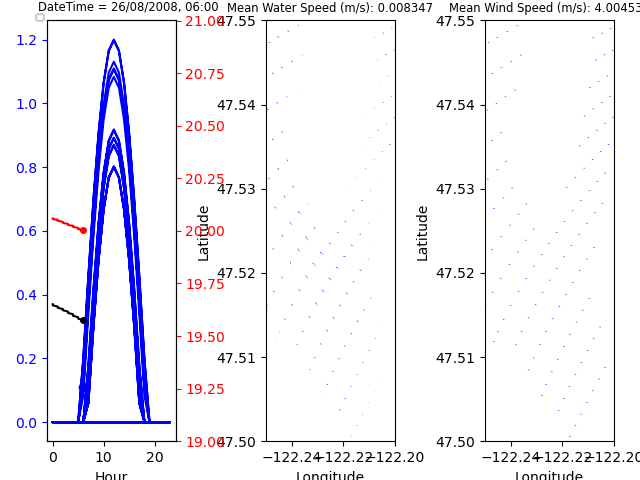

In [13]:
# FIGURE 1
# Sun radiation, USV power, water temperature
# Water speed
# Wind speed

fig, ax  = plt.subplots(1, 3)
ax2      = ax[0].twinx()
fig.tight_layout(h_pad = 2)

def update(frame):
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    ax2.clear()
    initFrame = (frame // 48) * 48
    
    mean_water_speed = np.mean(np.sqrt((water_x[frame][lyr][:])**2 + (water_y[frame][lyr][:])**2))
    mean_wind_speed  = np.mean(np.sqrt((wind_x[frame][:])**2 + (wind_y[frame][:])**2))
    
    myip = ip_vector[frame]
    plt.suptitle("DateTime = " + date[frame].strftime("%d/%m/%Y, %H:%M"), x = 0.2, y = 1, fontsize = 'small')
    ax[1].set_title(f"Mean Water Speed (m/s): {mean_water_speed:.6f}", fontsize = 'small')
    ax[2].set_title(f"Mean Wind Speed (m/s): {mean_wind_speed:.6f}", fontsize = 'small')
    
    ax[0].set_xlabel("Hour")
    ax[1].set_xlabel("Longitude")
    ax[2].set_xlabel("Longitude")

    ax[0].tick_params(axis = 'y', colors = 'blue')
    ax2.tick_params(axis = 'y', colors = 'red')
    ax[1].set_ylabel("Latitude")
    ax[2].set_ylabel("Latitude")

    ax2.set_ylim([19,21])
    
    ax[1].set_xlim(myxlim)
    ax[1].set_ylim(myylim)

    ax[2].set_xlim(myxlim)
    ax[2].set_ylim(myylim)
    
    # Legend
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc = "upper left", bbox_to_anchor = (0.05, 0.98), prop = {'size': 6})
    
    # GRAPHIC 1
    # ----------------------
    # Sun radiation
    ax[0].plot(hours, sun, color = "blue", label = "Sun Radiation")
    ax[0].plot(hours[frame], sun[frame], marker = 'o', color = "blue")
    
    # Water temperature
    ax2.plot(hours[initFrame : frame + 1], water_temp[lyr][myip][initFrame : frame + 1], color = "red", label = "Water Temperature (ºC)")
    ax2.plot(hours[frame], water_temp[lyr][myip][frame], color = "red", marker = "o", markersize = 4)
    
    # USV power
    ax[0].plot(hours[initFrame : frame + 1], v_usv_power[initFrame : frame + 1], color = "black", label = "Ship Power [0, 1]")
    ax[0].plot(hours[frame], v_usv_power[frame], color = "black", marker = 'o', markersize = 4)
    # ----------------------
    
    # GRAPHIC 2
    # ----------------------
    # Water speed
    ax[1].quiver(zonal_lon, zonal_lat, water_x[frame][lyr][:] / 10, water_y[frame][lyr][:] / 10, color = 'b')
    # ----------------------
    
    
    # GRAPHIC 3
    # ----------------------
    # Wind speed
    line = ax[2].quiver(zonal_lon, zonal_lat, wind_x[frame][:] / 10, wind_y[frame][:] / 10, color = 'b')
    # ----------------------

    return line

ani = FuncAnimation(fig, update, repeat = False, frames = len(hours), blit = True)
plt.subplots_adjust(wspace = 0.7)
plt.show()
#ani.save("figure1.gif", writer=anim.ImageMagickWriter(fps=30))
#ani.save("figure1.mp4", writer=anim.FFMpegWriter(fps=60))

<IPython.core.display.Javascript object>


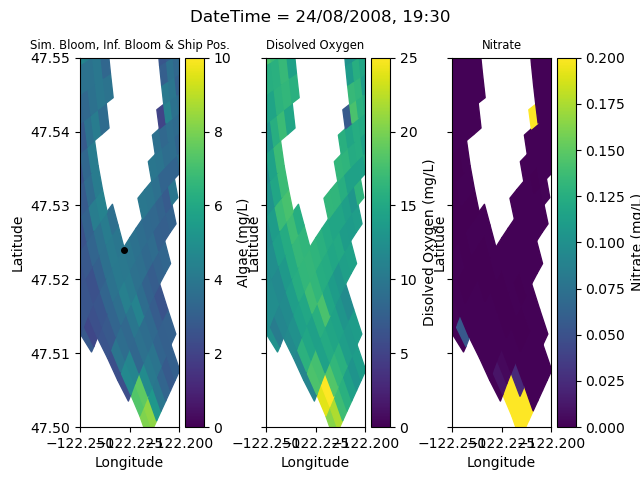

In [14]:
# FIGURE 2
# Algae, bloom position, USV position
# Disolved oxygen
# Nitrate

fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)
patches = []

# Colorbar subplot 1
cmap1   = plt.get_cmap('viridis')
norm1   = plt.Normalize(0, 10)
sm1     = plt.cm.ScalarMappable(cmap = cmap1)
sm1.set_clim(vmin = 0, vmax = 10)
cbar1   = plt.colorbar(sm1, ax = ax[0])
cbar1.set_label('Algae (mg/L)')

# Colorbar subplot 2
cmap2   = plt.get_cmap('viridis')
norm2   = plt.Normalize(0, 25)
sm2     = plt.cm.ScalarMappable(cmap = cmap2)
sm2.set_clim(vmin = 0, vmax = 25)
cbar2   = plt.colorbar(sm2, ax = ax[1])
cbar2.set_label('Disolved Oxygen (mg/L)')

# Colorbar subplot 3
cmap3   = plt.get_cmap('viridis')
norm3   = plt.Normalize(0, 0.2)
sm3     = plt.cm.ScalarMappable(cmap = cmap3)
sm3.set_clim(vmin = 0, vmax = 0.2)
cbar3   = plt.colorbar(sm3, ax = ax[2])
cbar3.set_label('Nitrate (mg/L)')

# Color map
for i in range(len(longitude)):
    verts   = np.column_stack((longitude[i], latitude[i])) 
    polygon = Polygon(verts, closed = True) 
    patches.append(polygon)

# One map for each subplot
collection1 = PatchCollection(patches)
collection2 = PatchCollection(patches) 
collection3 = PatchCollection(patches) 

def update(frame):
    ax[0].clear()
    ax[0].add_collection(collection1)
    
    ax[1].clear()
    ax[1].add_collection(collection2)
    
    ax[2].clear()
    ax[2].add_collection(collection3)
    
    plt.suptitle("DateTime = " + date[frame].strftime("%d/%m/%Y, %H:%M"))
    ax[0].set_title("Sim. Bloom, Inf. Bloom & Ship Pos.", fontsize = 'small')
    ax[1].set_title("Disolved Oxygen", fontsize = 'small')
    ax[2].set_title("Nitrate", fontsize = 'small')
        
    ax[0].set_xlabel("Longitude")
    ax[1].set_xlabel("Longitude")
    ax[2].set_xlabel("Longitude")
    
    ax[0].set_ylabel("Latitude")
    ax[1].set_ylabel("Latitude")
    ax[2].set_ylabel("Latitude")
    
    # GRAPHIC 1
    # ----------------------
    alg     = np.array(list(map(norm1, algae[frame][1][lyr][:])))
    colors1 = cmap1(alg)
    collection1.set_color(colors1)
    
    # Bloom trajectory
    circle  = Circle((v_bloom_lon[frame], v_bloom_lat[frame]), radius = 0.001 * math.sqrt(v_bloom_size[frame]), fill = False, color = "red") 
    ax[0].add_patch(circle)

    # USV trajectory
    ax[0].plot(v_usv_lon[frame], v_usv_lat[frame], color = "black", marker = 'o', markersize = 4)
    # ----------------------
    
    # GRAPHIC 2
    # ----------------------
    disox   = np.array(list(map(norm2, dox[frame][lyr][:])))
    colors2 = cmap2(disox)
    collection2.set_color(colors2)
    # ----------------------
    
    # GRAPHIC 3
    # ----------------------
    nit     = np.array(list(map(norm3, nox[frame][lyr][:])))
    colors3 = cmap3(nit)
    collection3.set_color(colors3)
    # ----------------------

    ax[0].set_xlim(myxlim)
    ax[0].set_ylim(myylim)
    
    ax[1].set_xlim(myxlim)
    ax[1].set_ylim(myylim)
    
    ax[2].set_xlim(myxlim)
    ax[2].set_ylim(myylim)
    
    ax[0].autoscale_view()
    ax[1].autoscale_view()
    line = ax[2].autoscale_view()

    return line

ani = FuncAnimation(fig, update, repeat = False, frames = len(hours), blit = True)
plt.subplots_adjust(wspace = 0.5)
plt.show()

<IPython.core.display.Javascript object>


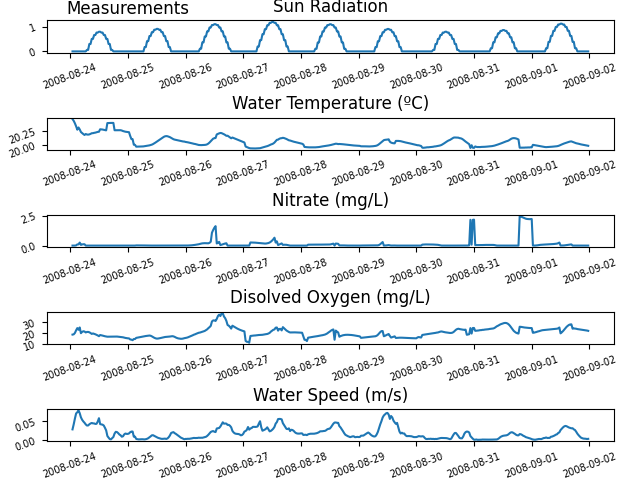

In [31]:
# FIGURE 3
# Measurements
fig, ax = plt.subplots(5, 1)
fig.tight_layout(h_pad = 2)

# Sun radiation
ax[0].set_title ('Sun Radiation')
ax[0].plot(date[ini_frame : end_frame], sun[ini_frame : end_frame])
ax[0].tick_params(labelrotation = 20, labelsize = 7)

# Water temperature
ax[1].set_title ('Water Temperature (ºC)')
ax[1].plot(date[ini_frame : end_frame], v_water_temp[ini_frame : end_frame])
ax[1].tick_params(labelrotation = 20, labelsize = 7)

# Nitrate
ax[2].set_title ('Nitrate (mg/L)')
ax[2].plot(date[ini_frame : end_frame], v_nitrate[ini_frame : end_frame])
ax[2].tick_params(labelrotation = 20, labelsize = 7)

# Disolved oxygen
ax[3].set_title ('Disolved Oxygen (mg/L)')
ax[3].plot(date[ini_frame : end_frame], v_oxygen[ini_frame : end_frame])
ax[3].tick_params(labelrotation = 20, labelsize = 7)

# Water speed
ax[4].set_title ('Water Speed (m/s)')
ax[4].plot(date[ini_frame : end_frame], v_water_speed[ini_frame : end_frame])
ax[4].tick_params(labelrotation = 20, labelsize = 7)

fig.suptitle('Measurements', x = 0.2, y = 1)
plt.subplots_adjust(hspace = 2)
plt.show()

<IPython.core.display.Javascript object>


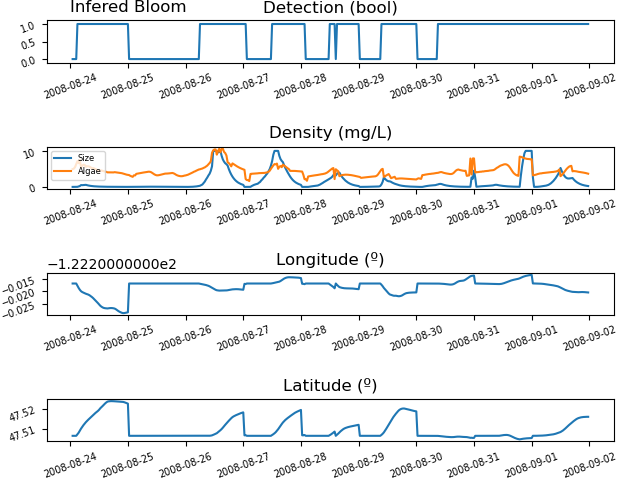

In [14]:
# FIGURE 4
# Bloom info
fig, ax = plt.subplots(4, 1)
fig.tight_layout(h_pad = 2)

# Bloom detection
ax[0].set_title ('Detection (bool)')
ax[0].set_ylim([-0.1, 1.1])
ax[0].set_yticks([0, 0.5, 1])
ax[0].plot(date[ini_frame : end_frame], v_bloom_detection[ini_frame : end_frame])
ax[0].tick_params(labelrotation = 20, labelsize = 7)

# Bloom density
ax[1].set_title ('Density (mg/L)')
ax[1].plot(date[ini_frame : end_frame], v_bloom_size[ini_frame : end_frame], label = "Size")
ax[1].plot(date[ini_frame : end_frame], v_algae[ini_frame : end_frame], label = "Algae")
ax[1].legend(loc = "upper left", prop = {'size': 6})
ax[1].tick_params(labelrotation = 20, labelsize = 7)

# Bloom longitude
ax[2].set_title ('Longitude (º)')
ax[2].plot(date[ini_frame : end_frame], v_bloom_lon[ini_frame : end_frame])
ax[2].tick_params(labelrotation = 20, labelsize = 7)

# Bloom latitude
ax[3].set_title ('Latitude (º)')
ax[3].plot(date[ini_frame : end_frame], v_bloom_lat[ini_frame : end_frame])
ax[3].tick_params(labelrotation = 20, labelsize = 7)

fig.suptitle('Infered Bloom', x = 0.2, y = 1)
plt.subplots_adjust(hspace = 2)
plt.show()

<IPython.core.display.Javascript object>


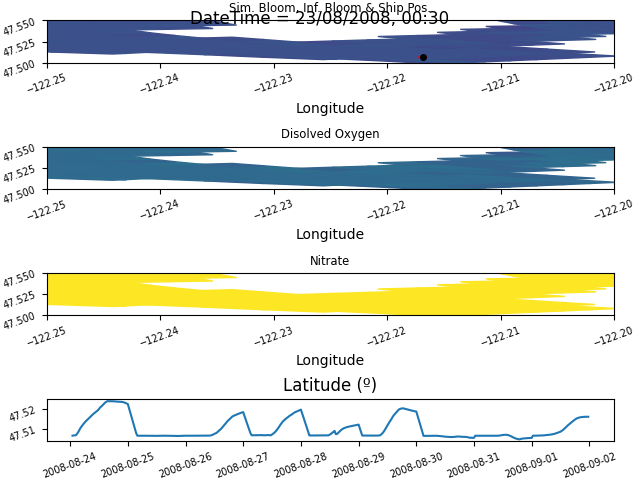

In [17]:
# FIGURE 5
# USV info
fig, ax = plt.subplots(4, 1)
fig.tight_layout(h_pad = 2)

# USV power
ax[0].set_title ('Electric Power [0,1]')
ax[0].plot(date[ini_frame : end_frame], v_usv_power[ini_frame : end_frame], label = "Battery")
ax[0].plot(date[ini_frame : end_frame], sun[ini_frame : end_frame], label = "Sun")
ax[0].legend(loc = "upper left", prop = {'size': 6})
ax[0].tick_params(labelrotation = 20, labelsize = 7)

# USV speed
ax[1].set_title ('Speed (km/h)')
speed = np.sqrt(np.diff(np.array(v_usv_lon))**2 + np.diff(np.array(v_usv_lat))**2) * 2 * np.pi * 6700 / 360 * 2
ax[1].plot(date[ini_frame : end_frame], speed[ini_frame : end_frame])
ax[1].tick_params(labelrotation = 20, labelsize = 7)

# USV longitude
ax[2].set_title ('Longitude (º)')
ax[2].plot(date[ini_frame : end_frame], v_usv_lon[ini_frame : end_frame])
ax[2].tick_params(labelrotation = 20, labelsize = 7)

# USV latitude
ax[3].set_title ('Latitude (º)')
ax[3].plot(date[ini_frame : end_frame], v_usv_lat[ini_frame : end_frame])
ax[3].tick_params(labelrotation = 20, labelsize = 7)

fig.suptitle('USV', x = 0.2, y = 1)
plt.subplots_adjust(hspace = 2)
plt.show()

<IPython.core.display.Javascript object>


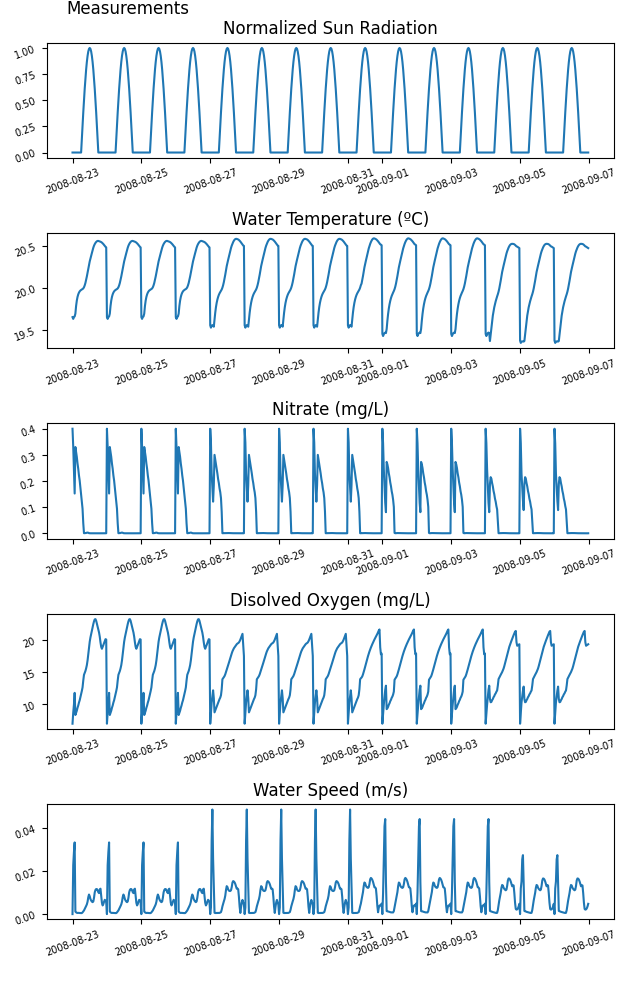

In [65]:
import pandas as pd

# FIGURE 3: Measurements
BASE_DIR = "../output/ModelBeatrizTFM_reports"

fig, ax = plt.subplots(5, 1)
fig.tight_layout(h_pad = 0.5)
fig.set_figheight(10)

# Sun radiation
df = pd.read_csv(BASE_DIR + "/FogServer.SimSenS.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
# data_sun.info()
ax[0].set_title ('Normalized Sun Radiation')
ax[0].plot(df["timestamp"], df["SUN"])
ax[0].tick_params(labelrotation = 20, labelsize = 7)

# Water temperature
df = pd.read_csv(BASE_DIR + "/FogServer.SimSenT.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
ax[1].set_title ('Water Temperature (ºC)')
ax[1].plot(df["timestamp"], df["WTE"])
ax[1].tick_params(labelrotation = 20, labelsize = 7)

# Nitrate
df = pd.read_csv(BASE_DIR + "/FogServer.SimSenN.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
ax[2].set_title ('Nitrate (mg/L)')
ax[2].plot(df["timestamp"], df["NOX"])
ax[2].tick_params(labelrotation = 20, labelsize = 7)

# Disolved oxygen
df = pd.read_csv(BASE_DIR + "/FogServer.SimSenO.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
ax[3].set_title ('Disolved Oxygen (mg/L)')
ax[3].plot(df["timestamp"], df["DOX"])
ax[3].tick_params(labelrotation = 20, labelsize = 7)

# Water speed
df1 = pd.read_csv(BASE_DIR + "/FogServer.SimSenU.csv")
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df2 = pd.read_csv(BASE_DIR + "/FogServer.SimSenV.csv")
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
ax[4].set_title ('Water Speed (m/s)')
ax[4].plot(df["timestamp"], np.sqrt(df1["WFU"]**2+df2["WFV"]**2))
ax[4].tick_params(labelrotation = 20, labelsize = 7)

fig.suptitle('Measurements', x = 0.2, y=1)
# plt.subplots_adjust(hspace = 2)
plt.show()
plt.savefig(BASE_DIR + "/figure3.png", dpi=400, bbox_inches='tight')